<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Demos/TimeSeries_FrequencyDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series class: frequency analysis demo

See also https://academo.org/demos/spectrum-analyzer/ and related demo https://academo.org/demos/wave-interference-beat-frequency/

Another nice demo: https://musiclab.chromeexperiments.com/spectrogram/

In [28]:
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
import scipy.signal as sig
import matplotlib.pyplot as plt

In [6]:
# Download some music, e.g.,
# https://en.wikipedia.org/wiki/File:Richard_Wagner_-_Ride_of_the_Valkyries.ogg
!wget 'https://upload.wikimedia.org/wikipedia/commons/2/29/Richard_Wagner_-_Ride_of_the_Valkyries.ogg'

--2022-03-11 04:51:05--  https://upload.wikimedia.org/wikipedia/commons/2/29/Richard_Wagner_-_Ride_of_the_Valkyries.ogg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2298306 (2.2M) [application/ogg]
Saving to: ‘Richard_Wagner_-_Ride_of_the_Valkyries.ogg’

Richard_Wagner_-_Ri 100%[===================>]   2.19M  --.-KB/s    in 0.1s    

2022-03-11 04:51:06 (16.7 MB/s) - ‘Richard_Wagner_-_Ride_of_the_Valkyries.ogg’ saved [2298306/2298306]



In [22]:
# !ffmpeg -i Richard_Wagner_-_Ride_of_the_Valkyries.ogg Valkyries.wav # 2.2 MB --> 22 MB !!
!ffmpeg -v 0 -t 00:00:30 -i Richard_Wagner_-_Ride_of_the_Valkyries.ogg Valkyries_short.wav # first 30 seconds

File 'Valkyries_short.wav' already exists. Overwrite ? [y/N] y


In [24]:
samplerate, data = wavfile.read('Valkyries_short.wav')

## Let's listen to the audio clip

In [27]:
print("Original audio clip")
Audio(data,rate=float(samplerate))

Original audio clip


## Look at the periodogram
At it's heart, this is the Fourier transform

("Periodogram" is special terminology we use for a **stationary** signal... and of course music is **not** stationary, but it still leads to useful methods)

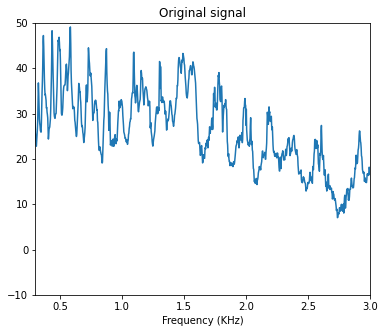

In [67]:
def periodogram(*args,**kwargs):
  return sig.welch(*args,**kwargs,window='barthann',scaling='density')

# Convert to decibels (dB)
dbPower = lambda f : 10*np.log10(np.abs(f))
dbAmplitude = lambda f : 20*np.log10(np.abs(f))

f, Pxx = periodogram(data,fs=float(samplerate),nperseg=2**14)
fig, ax1 = plt.subplots(1,1, figsize=(6,5))
ax1.plot(f/1000, dbPower(Pxx))
ax1.set_title('Original signal')
plt.xlabel('Frequency (KHz)')
plt.xlim((.3,3))
plt.ylim((-10,50))
plt.show()

## Let's break it down by time
The spectrogram (Fourier transform) is for the whole signal, so we see what notes were played, but not when they were played

The **spectrogram** splits the signal into time chunks and analyzes each chunk separately

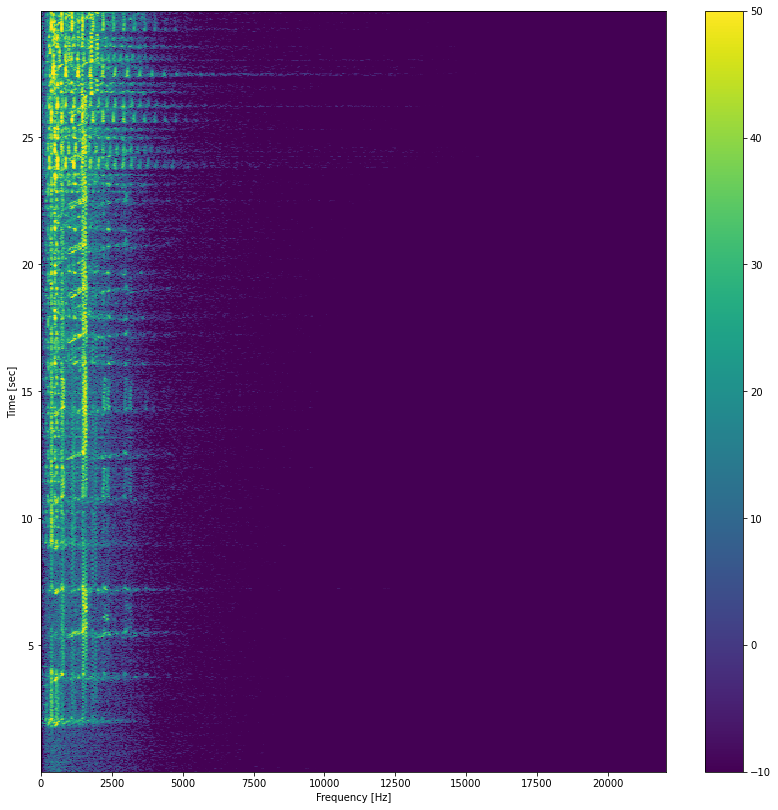

In [70]:
fig = plt.figure(figsize=(14,14))
f, t, Sxx = sig.spectrogram(data, fs=float(samplerate), window='barthann', nperseg=2**10,
    scaling='density')
plt.pcolormesh(f, t, dbPower(Sxx.T), vmin=-10,vmax=50)
plt.colorbar()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time [sec]')
plt.show()

## Let's make some synthetic sounds
In Western music, the note "middle A" is usually 440 Hz or so; see https://en.wikipedia.org/wiki/A440_(pitch_standard)

Our sample rate is 44100, meaning 44.1 kHz... and this means our sample can represent frequencies up to 22.05 kHz  (why divide by 2? Think of allowing negative frequencies too... and doing that allows to incorporate the notion of *phase*)

A child can hear up to about 20 kHz or so; an older adult can hear up to maybe 15 kHz (these numbers vary... look on the internet for more precise data since I'm an applied mathematician so you shouldn't trust me at all).

In [127]:
# Now let's make our own sound

# Fs = 3080 # in Hz.  3080 is a perfect multiple of 440, and sound is a bit different
Fs = 3079
T  = 5    # in seconds
t  = np.arange(1,T*Fs)
def sin(frequency_in_Hz):
  return np.sin(2*np.pi*frequency_in_Hz*t/Fs)

A = 440

x  = sin(A) + 1

Audio(x,rate=Fs)

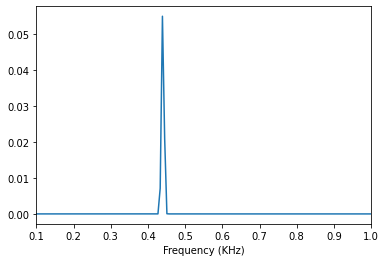

In [128]:
f, Pxx = periodogram(x,fs=Fs,nperseg=2**9)
plt.plot(f/1000, Pxx)
plt.xlabel('Frequency (KHz)')
plt.xlim((.1,1))
plt.show()

Btw, why did we add $+1$ to the sin?  Because negative sound doesn't make sense

What is sound? ... pressure waves aka [acoustic waves](https://en.wikipedia.org/wiki/Acoustic_wave).

Solid media can have other types of sound: Earthquakes travel in both 
- P waves (primary wave or pressure wave), and 
- S waves (secondary or shear wave)

Electromagnetic radiation [doesn't have a medium it travels through](https://en.wikipedia.org/wiki/Michelson%E2%80%93Morley_experiment) and *can* have negative values

## Fancier sound: let's make a major chord

In [129]:
C_sharp = 2**(4/12)*A # major third above A
E       = 2**(7.01955/12)*A # a perfect fifth above A

x_major  = sin(A) + sin(C_sharp) + sin(E) + 1

Audio(x_major,rate=Fs)

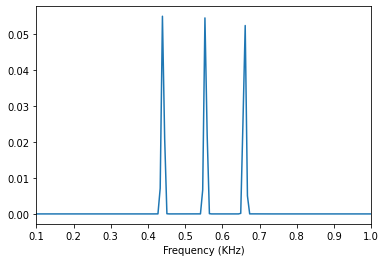

In [130]:
f, Pxx_major = periodogram(x_major,fs=Fs,nperseg=2**9)
plt.plot(f/1000, Pxx_major)
plt.xlabel('Frequency (KHz)')
plt.xlim((.1,1))
plt.show()

In [131]:
# and a minor chord
C       = 2**(3/12)*A # minor third above A
E       = 2**(7.01955/12)*A # a perfect fifth above A

x_minor  = sin(A) + sin(C) + sin(E) + 1

Audio(x_minor,rate=Fs)

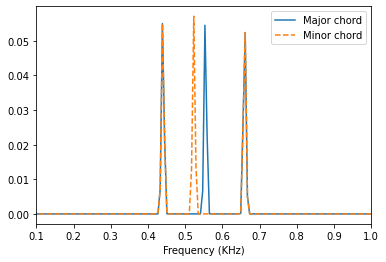

In [132]:
f, Pxx_major = periodogram(x_major,fs=Fs,nperseg=2**9)
f, Pxx_minor = periodogram(x_minor,fs=Fs,nperseg=2**9)
plt.plot(f/1000, Pxx_major, label='Major chord')
plt.plot(f/1000, Pxx_minor, '--', label='Minor chord')
plt.xlabel('Frequency (KHz)')
plt.xlim((.1,1))
plt.legend()
plt.show()